# Data Science in Marketing 

## Introduction

This notebook is an example of how to use the Data Science in Marketing dataset.

## How to use
import the dataset FROM THIS LINK
https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip




In [1]:
!pip install openpyxl -q


In [2]:
import pandas as pd
import os
from sqlalchemy import create_engine
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Reading retail dataset into Pandas dataframe

In [3]:
transactions_df =  pd.read_excel('online_retail_II.xlsx')
transactions_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Dataset has 8 columns with following descriptions.



InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.

UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).

CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal. The name of the country where a customer resides.

In [5]:
transactions_df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [6]:
transactions_df.shape

(525461, 8)

Dropping rows with N/A values, renaming columns.

In [16]:
transactions_df_cp= transactions_df.copy()
transactions_df_cp =transactions_df_cp.dropna()
transactions_df_cp.columns=['invoice_id', 'product_id', 'description', "quantity", 'invoice_date','price', 'customer_id', 'country']
transactions_df_cp['customer_id'] =transactions_df_cp['customer_id'].astype(int)

Example: show customer transactions before featurization

In [20]:
CUSTOMER_ID_EXAMPLE= 13085
# transactions_df_cp[ transactions_df_cp['customer_id'] == CUSTOMER_ID_EXAMPLE]
transactions_df_cp[transactions_df_cp.customer_id == CUSTOMER_ID_EXAMPLE]

,invoice_id,product_id,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
...,...,...,...,...,...,...,...,...
74409,496166,79323W,WHITE CHERRY LIGHTS,8,2010-01-29 11:42:00,6.75,13085,United Kingdom
74410,496166,21137,BLACK RECORD COVER FRAME,8,2010-01-29 11:42:00,3.75,13085,United Kingdom
74411,496166,22041,"RECORD FRAME 7"" SINGLE SIZE",6,2010-01-29 11:42:00,2.55,13085,United Kingdom
74412,496166,40046A,RED DAISY PAPER LAMPSHADE,12,2010-01-29 11:42:00,1.25,13085,United Kingdom


Defining Customers' Features

In [21]:
def is_weekend(transaction_date):
    # Check if the day of the week is either Saturday (5) or Sunday (6) return transaction_date.weekday() in [5, 6]
    return transaction_date.weekday() in [5, 6]

In [22]:
def generate_customer_features(df):
    df['is_weekend'] = df['invoice_date'].apply(is_weekend)
    # Group the DataFrame by 'Customer ID'
    grouped = df.groupby('customer_id')

    # Calculate the average basket size by customer
    avg_basket_size = grouped['quantity'].mean()

    # Calculate the average monthly transaction price by customer (excluding the refunds)
    df['transaction_price'] = df['quantity'] * df['price']
    df['transaction_price'] = df.apply(lambda row: row['quantity'] * row['price']
    if row['quantity'] > 0 and row['price'] > 8 else 8, axis=1)

    df['year_month'] = df['invoice_date'].dt.to_period('M')

    avg_monthly_transaction_price = df.groupby(['customer_id', 'year_month'])['transaction_price'].sum().groupby(
        'customer_id').mean()

    # Calculate the average quantity price on weekends by customer
    avg_weekend_quantity_price = grouped.apply(lambda x: (x['is_weekend'] * x['transaction_price']).mean())

    # Calculate the average monthly returns by customer
    df['returns'] = df['quantity'] * df['price'] < 0

    avg_monthly_returns = df.groupby(['customer_id', 'year_month'])['returns'].mean().groupby('customer_id').mean()
    # Create a DataFrame to store the customer features
    customer_features = pd.DataFrame({'average_basket_size': avg_basket_size,
                                      'average_monthly_transaction_price': avg_monthly_transaction_price,
                                      'average_weekend_transaction_price': avg_weekend_quantity_price,
                                      'average_monthly_returns': avg_monthly_returns})
    return customer_features

In [23]:
#Generate customer features
customer_features = generate_customer_features (transactions_df_cp)

Show CUSTOMER_ID_EXAMPLE customer after Featurization and before Scaling

In [25]:
customer_features[customer_features.index == CUSTOMER_ID_EXAMPLE]


,average_basket_size,average_monthly_transaction_price,average_weekend_transaction_price,average_monthly_returns
customer_id,,,,
13085,11.539683,168.0,0.0,0.333333


In [26]:
from sklearn.preprocessing import MinMaxScaler

Scaling features between 0 and 1

In [29]:
#Instantiate the Min-Max Scaler
scaler = MinMaxScaler()

# Fit the scaler on the data and transform the data 
scaled_customer_features = scaler.fit_transform(customer_features)

# Convert the scaled data back to a DataFrame
scaled_customer_features_df = pd.DataFrame(scaled_customer_features, columns=customer_features.columns)
scaled_customer_features_df2 = scaled_customer_features_df.copy()
scaled_customer_features_df2['customer_id'] = customer_features.index

In [31]:
scaled_customer_features_df2[scaled_customer_features_df2.customer_id==CUSTOMER_ID_EXAMPLE]

,average_basket_size,average_monthly_transaction_price,average_weekend_transaction_price,average_monthly_returns,customer_id
507,0.006873,0.011484,0.0,0.333333,13085


In [33]:
scaled_customer_features_df.shape

(4383, 4)

Clustering customers' scaled features

In [37]:
from sklearn.cluster import KMeans
# Number of clusters (K)
n_clusters = 3

# Instantiate the KMeans model kmeans 
kmeans = KMeans(n_clusters=n_clusters, random_state=43)

# Fit the model to the scaled data 
kmeans.fit(scaled_customer_features_df)
#Add cluster labels to the original customer features DataFrame 
customer_features['Cluster'] = kmeans. labels_

# merge the clusters with the original dataframe
transactions_with_clusters_df = pd.merge(transactions_df_cp, customer_features, on='customer_id')

C:\Users\Nile Crocodile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Visualize the clusters

C:\Users\Nile Crocodile\AppData\Local\Temp\ipykernel_15596\606847773.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = transactions_with_clusters_df, x = 'Cluster', palette = 'Set1', ax = axes[0])
C:\Users\Nile Crocodile\AppData\Local\Temp\ipykernel_15596\606847773.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=transactions_with_clusters_df, x='Cluster', palette='Set1', ax=axes[1])


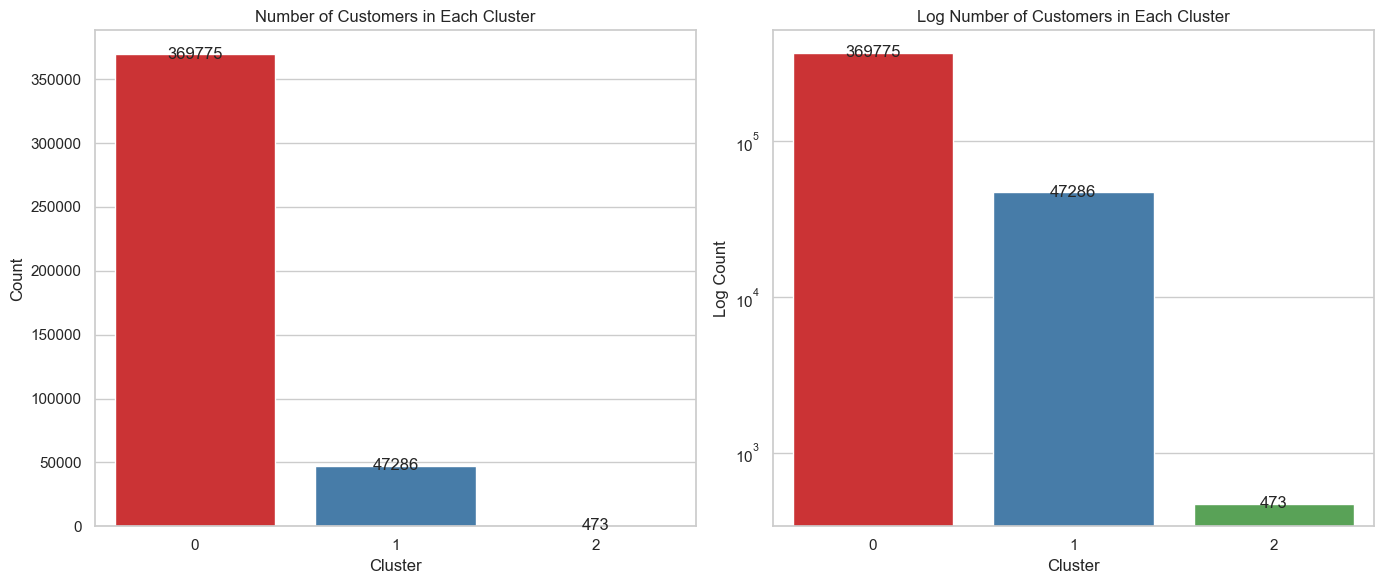

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set(style="whitegrid")

# Create subplats for both the regular and log-transformed plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Number of customers in each cluster
sns.countplot(data = transactions_with_clusters_df, x = 'Cluster', palette = 'Set1', ax = axes[0])
axes[0].set_title('Number of Customers in Each Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count')

# Annotate the bars with the count values on top
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                     va='center')

# Plot 2: Log-transformed number of customers in each cluster

sns.countplot(data=transactions_with_clusters_df, x='Cluster', palette='Set1', ax=axes[1])
axes[1].set_yscale('log')

# Apply log scale to the y-axis
axes[1].set_title('Log Number of Customers in Each Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel("Log Count")

# Annotate the bars with the count values on top (log scale)
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                     va='center')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

C:\Users\Nile Crocodile\AppData\Local\Temp\ipykernel_15596\3931257503.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=transactions_with_clusters_df, x='Cluster', y=feature, palette='Set1')
C:\Users\Nile Crocodile\AppData\Local\Temp\ipykernel_15596\3931257503.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=transactions_with_clusters_df, x='Cluster', y=feature, palette='Set1')
C:\Users\Nile Crocodile\AppData\Local\Temp\ipykernel_15596\3931257503.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=transactions_with_clu

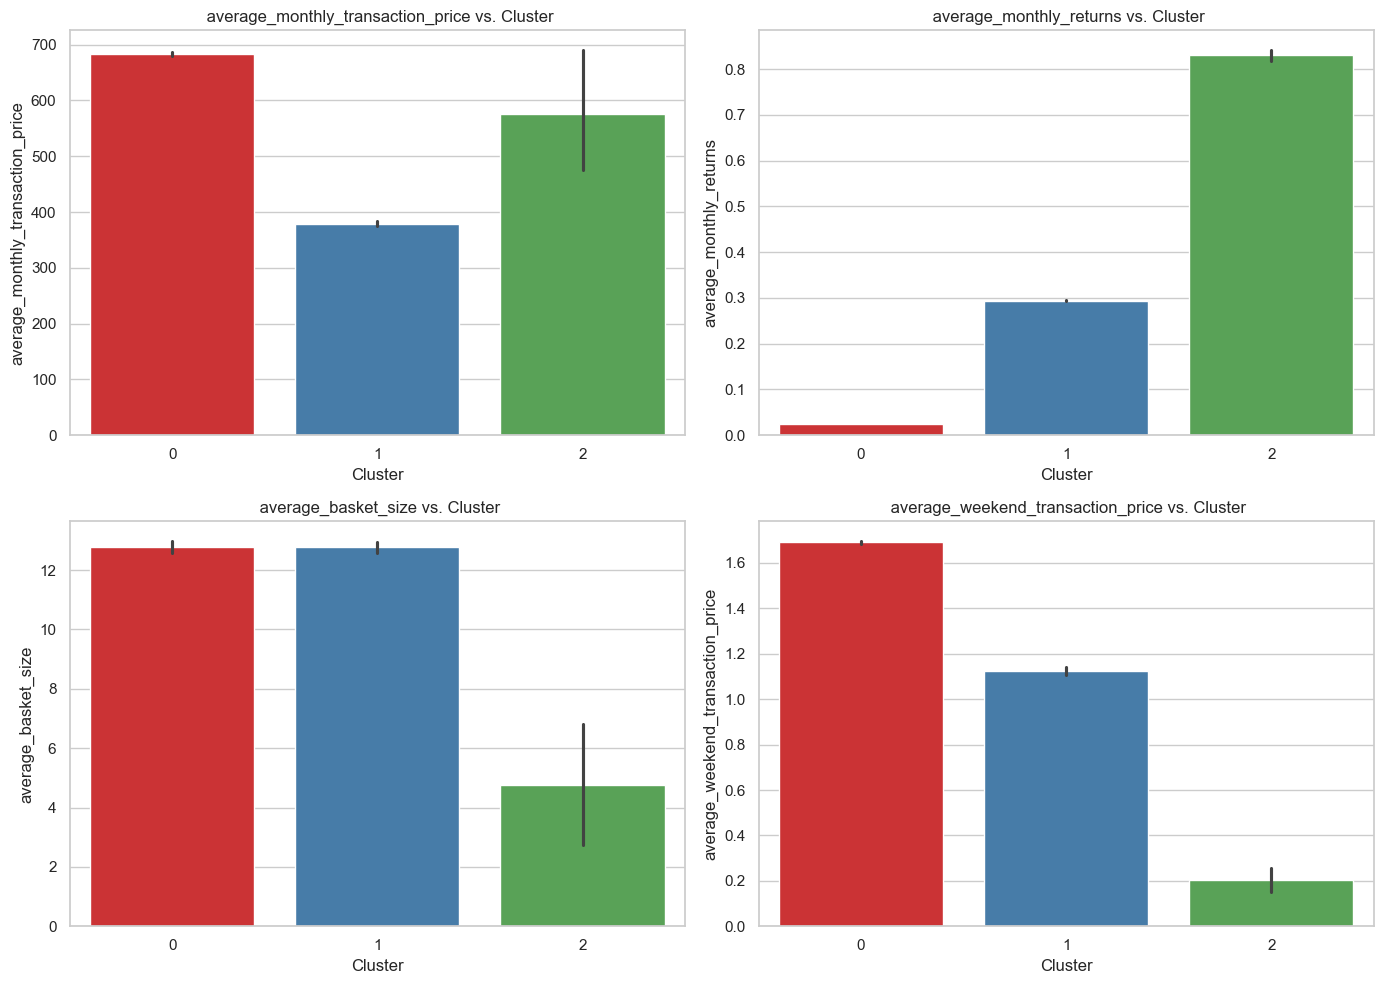

In [52]:
#Set the style of the plots 
sns.set(style="whitegrid")

# Define a list of features to visualize 	average_monthly_returns	customer_id
features_to_visualize = ['average_monthly_transaction_price', 'average_monthly_returns', 'average_basket_size', 'average_weekend_transaction_price']

# Create subplots for each feature
plt.figure(figsize=(14, 10))

for i, feature in enumerate(features_to_visualize, 1):
    plt.subplot(2, 2, i) # Create a 2x2 grid of subplots
    sns.barplot(data=transactions_with_clusters_df, x='Cluster', y=feature, palette='Set1')
    plt.title(f' {feature} vs. Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

# Adjust layout
plt.tight_layout()

C:\Users\Nile Crocodile\AppData\Local\Temp\ipykernel_15596\3068557471.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=transactions_with_clusters_df, x='Cluster', y='average_monthly_transaction_price', palette='Set1')


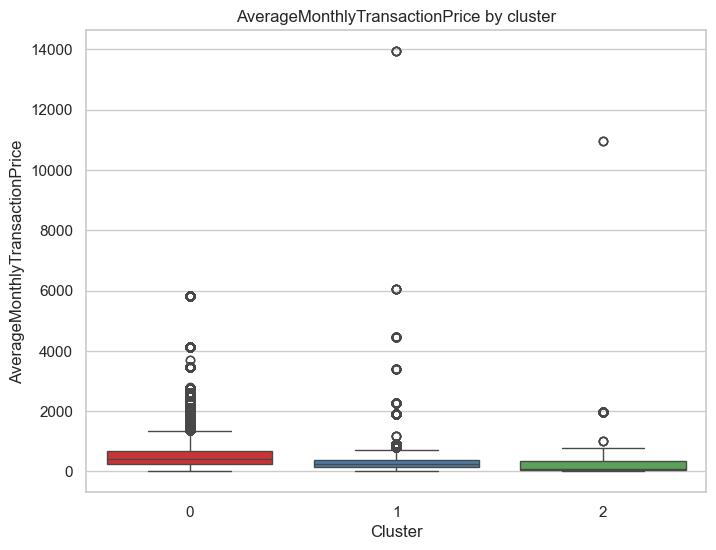

In [53]:
sns.set(style="whitegrid")

#create a box plot for AverageMonthlyTransactionPrice by cluster
plt.figure(figsize=(8,6))

sns.boxplot(data=transactions_with_clusters_df, x='Cluster', y='average_monthly_transaction_price', palette='Set1')
plt.title('AverageMonthlyTransactionPrice by cluster')
plt.xlabel('Cluster')
plt.ylabel('AverageMonthlyTransactionPrice')

plt.show()


Visualizing the Customer Clusters in 2-D dimensions

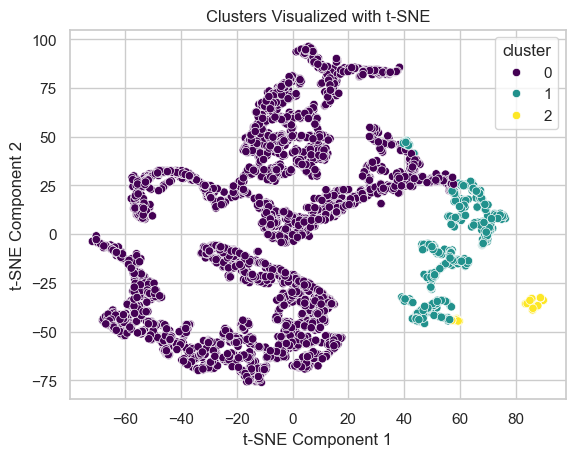

In [68]:
import sklearn.decomposition as pca
import sklearn.manifold as TSNE
import sklearn.preprocessing as StanderScaler

tsne = TSNE.TSNE(n_components=2, random_state=42, n_iter=2000)
x_tsne = tsne.fit_transform(scaled_customer_features)

df_tsne = pd.DataFrame(data=x_tsne, columns=['t-SNE Component 1', 't-SNE Component 2'])
df_tsne['cluster'] = kmeans.labels_

sns.scatterplot(x='t-SNE Component 1', y='t-SNE Component 2', hue='cluster', data=df_tsne, palette='viridis')
plt.title('Clusters Visualized with t-SNE')
plt.show()